In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
# Carga de datos
cd = pd.read_csv('Datos_Limpios_portland.csv') 
cd = cd.drop(['Unnamed: 0'], axis=1)
cd.head()

,Unnamed: 0.1,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_verifications,neighbourhood_cleansed,property_type,room_type,bathrooms_text,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,18/04/2011,a few days or more,0%,6%,"['email', 'phone']",Hadern,Entire rental unit,Entire home/apt,1 bath,...,4.81,4.90,4.93,4.78,4.73,2.0,2.0,0.0,0.0,0.80
1,1,12/05/2011,within an hour,100%,99%,"['email', 'phone']",Berg am Laim,Entire rental unit,Entire home/apt,1 bath,...,4.95,4.97,5.00,4.66,4.61,3.0,3.0,0.0,0.0,0.46
2,2,01/07/2011,within an hour,100%,78%,"['email', 'phone']",Pasing-Obermenzing,Entire rental unit,Entire home/apt,1 bath,...,4.27,4.78,4.80,4.59,4.44,1.0,1.0,0.0,0.0,0.26
3,3,14/04/2010,within a few hours,100%,100%,"['email', 'phone']",Sendling-Westpark,Private room in home,Private room,1 shared bath,...,4.99,4.99,4.98,4.77,4.91,1.0,0.0,1.0,0.0,3.58
4,4,16/07/2011,within an hour,100%,67%,"['email', 'phone']",Maxvorstadt,Private room in rental unit,Private room,1 shared bath,...,4.91,4.89,4.88,4.82,4.79,1.0,0.0,1.0,0.0,0.74


In [3]:
#Filtrar y transformar la variable "host_acceptance_rate"
#    - Primero eliminamos las filas donde "host_acceptance_rate" sea "S/D"
#    - Después, removemos el carácter "%" y convertimos la columna a tipo float


cd = cd[cd['host_acceptance_rate'] != 'S/D']
cd['host_acceptance_rate'] = (
    cd['host_acceptance_rate']
    .astype(str)  # Convertimos a string para usar .str
    .str.replace('%', '', regex=True)  # Quitamos el '%'
    .astype(float)  # Convertimos a float
)




In [4]:
# Convertir la variable "host_is_superhost" a valores numéricos
#    - Sustituimos la 't' por 1 y la 'f' por 0
#    - Con astype(int), confirmamos el tipo de dato numérico entero

cd['host_is_superhost'] = (
    cd['host_is_superhost']
    .replace({'t': 1, 'f': 0})
    .astype(int)
)

KeyError: 'host_is_superhost'

In [5]:
# Crear la columna "bathrooms" a partir de "bathrooms_text"
#    - Extraemos únicamente el número que aparece en "bathrooms_text" (puede ser decimal)
#    - Convertimos esos valores a float
#    - Eliminamos las filas que tengan valores nulos en "bathrooms" para evitar problemas

cd['bathrooms'] = (
    cd['bathrooms_text']
    .str.extract(r'(\d+\.?\d*)')
    .astype(float)
)
cd = cd[cd['bathrooms'].notnull()]

In [6]:
 # Convertir "instant_bookable" a valores numéricos
#    - De la misma forma que con "host_is_superhost": 't' → 1, 'f' → 0

cd['instant_bookable'] = (
    cd['instant_bookable']
    .replace({'t': 1, 'f': 0})
    .astype(int)  # Conversión explícita para evitar FutureWarning
)


C:\Users\hp\AppData\Local\Temp\ipykernel_14844\2502022452.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'t': 1, 'f': 0})
C:\Users\hp\AppData\Local\Temp\ipykernel_14844\2502022452.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd['instant_bookable'] = (


In [7]:
#Convertir la columna "property_type" a valores numéricos
#    - Cada tipo de propiedad se asocia con un código entero según el diccionario "types"
# ---------------------------------------------------------------------------------
types = {
    'Entire rental unit': 1,
    'Entire condo': 2,
    'Private room in rental unit': 3,
    'Private room in home': 4,
    'Entire loft': 5,
    'Entire serviced apartment': 6
}
cd['property_type'] = cd['property_type'].replace(types)



C:\Users\hp\AppData\Local\Temp\ipykernel_14844\3821229496.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd['property_type'] = cd['property_type'].replace(types)


In [8]:
# -------------------------------------------------------------------------
# 1) Crear dataframes separados según el tipo de habitación ('room_type')
#    - Se filtra el dataframe original (cd) según los valores de la columna room_type.
# -------------------------------------------------------------------------
cd_entire = cd[cd['room_type'] == 'Entire home/apt']   # Alojamientos completos
cd_private = cd[cd['room_type'] == 'Private room']     # Habitaciones privadas
cd_shared = cd[cd['room_type'] == 'Shared room']       # Habitaciones compartidas
cd_hotel = cd[cd['room_type'] == 'Hotel room']         # Habitaciones de hotel

# -------------------------------------------------------------------------
# 2) Mostrar la frecuencia de cada tipo de habitación en cada subset
#    - Utilizamos 'value_counts()' para contar cuántas filas hay de cada tipo.
#    - El argumento 'end="\n\n"' agrega un salto de línea extra entre cada impresión.
# -------------------------------------------------------------------------
print(cd_entire['room_type'].value_counts(), end='\n\n')
print(cd_private['room_type'].value_counts(), end='\n\n')
print(cd_shared['room_type'].value_counts(), end='\n\n')
print(cd_hotel['room_type'].value_counts(), end='\n\n')


room_type
Entire home/apt    2519
Name: count, dtype: int64

room_type
Private room    1261
Name: count, dtype: int64

room_type
Shared room    18
Name: count, dtype: int64

room_type
Hotel room    15
Name: count, dtype: int64



In [9]:
cd_entire['price'] = (
    cd_entire['price']
    .astype(str)  # Convertimos a string para asegurarnos
    .str.replace('[$,]', '', regex=True)  # Eliminamos '$' y ','
    .astype(float)  # Convertimos a float
)

model = LinearRegression()
model.fit(cd_entire[['host_acceptance_rate']], cd_entire['price'])  # Ahora debe funcionar


C:\Users\hp\AppData\Local\Temp\ipykernel_14844\1328563193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd_entire['price'] = (


LinearRegression()

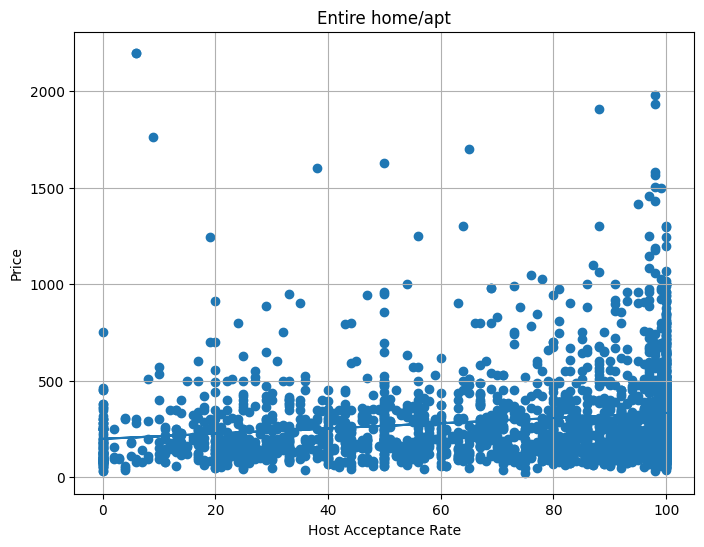

In [10]:

# 1) Crear y ajustar un modelo de regresión lineal
#    - Usamos 'host_acceptance_rate' como variable independiente (X).
#    - Definimos 'price' como variable dependiente (y).

model = LinearRegression()
model.fit(cd_entire[['host_acceptance_rate']], cd_entire['price'])


# 2) Visualizar la regresión lineal
#    - Generamos un diagrama de dispersión (scatter plot) con los datos reales.
#    - Sobre la misma gráfica, dibujamos la línea de mejor ajuste que produce el modelo.

plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura
plt.scatter(cd_entire[['host_acceptance_rate']], cd_entire['price'])
plt.plot(
    cd_entire[['host_acceptance_rate']],
    model.predict(cd_entire[['host_acceptance_rate']])
)
plt.title('Entire home/apt')         # Título de la gráfica
plt.xlabel('Host Acceptance Rate')   # Etiqueta del eje X
plt.ylabel('Price')                  # Etiqueta del eje Y
plt.grid(True)                       # Muestra una cuadrícula para facilitar la lectura
plt.show()                           # Muestra la gráfica


In [11]:

# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo

m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)


# 2) Representar el modelo lineal de forma explícita
#    - Mostramos la ecuación en el formato y = m*x + b.

print(f'y = {m[0]}x + {b}', end='\n\n')


# 3) Evaluar el modelo con un indicador de desempeño
#    - Utilizamos model.score() para obtener el R^2, que mide qué tan bien el modelo
#      se ajusta a los datos (1 significa un ajuste perfecto, 0 significa nulo).

print('Puntaje del modelo:', model.score(cd_entire[['host_acceptance_rate']], cd_entire['price']))


Pendiente: [1.34753553]
Intercepto: 198.53665614507634
y = 1.3475355252222307x + 198.53665614507634

Puntaje del modelo: 0.0314525492523684


In [12]:
# Asegurar que 'price' esté en formato numérico
cd_private['price'] = (
    cd_private['price']
    .astype(str)  # Convertimos a string para evitar errores
    .str.replace('[$,]', '', regex=True)  # Eliminamos '$' y ','
    .astype(float)  # Convertimos a float
)

# Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(cd_private[['host_acceptance_rate']], cd_private['price'])  # Ahora debe funcionar


C:\Users\hp\AppData\Local\Temp\ipykernel_14844\3380837372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd_private['price'] = (


LinearRegression()

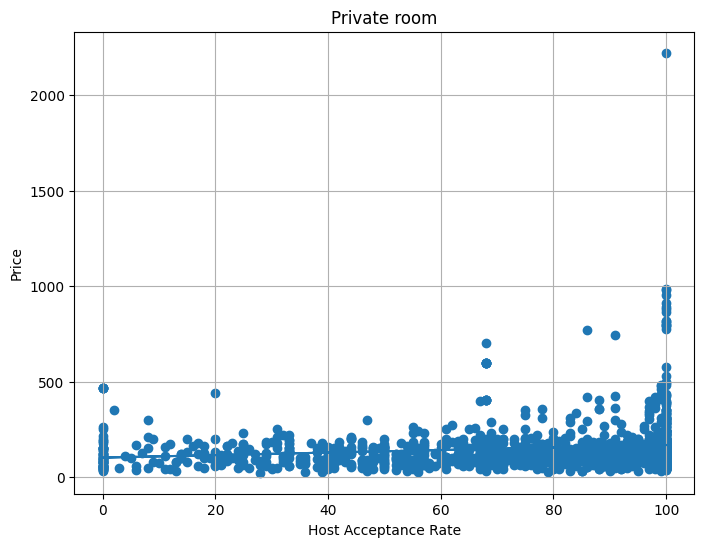

In [13]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_private[['host_acceptance_rate']], cd_private['price'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura
plt.scatter(cd_private[['host_acceptance_rate']], cd_private['price'])
plt.plot(
    cd_private[['host_acceptance_rate']],
    model.predict(cd_private[['host_acceptance_rate']])
)
plt.title('Private room')           # Título de la gráfica
plt.xlabel('Host Acceptance Rate')  # Etiqueta del eje X
plt.ylabel('Price')                 # Etiqueta del eje Y
plt.grid(True)                      # Activa la cuadrícula para una lectura más sencilla
plt.show()                          # Muestra la gráfica


In [14]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_private[['host_acceptance_rate']], cd_private['price']))


Pendiente: [0.65906915]
Intercepto: 102.12303583912757
y = 0.6590691506441578x + 102.12303583912757

Puntaje del modelo: 0.021213583007847814


In [15]:
# Convertir 'host_acceptance_rate' a float 
cd_shared['host_acceptance_rate'] = (
    cd_shared['host_acceptance_rate']
    .astype(str)  # Convertimos a string
    .str.replace('%', '', regex=True)  # Eliminamos '%'
    .astype(float)  # Convertimos a float
)

# Convertir 'price' a float 
cd_shared['price'] = (
    cd_shared['price']
    .astype(str)  # Convertimos a string
    .str.replace('[$,]', '', regex=True)  # Eliminamos '$' y ','
    .astype(float)  # Convertimos a float
)


C:\Users\hp\AppData\Local\Temp\ipykernel_14844\2783552561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd_shared['host_acceptance_rate'] = (
C:\Users\hp\AppData\Local\Temp\ipykernel_14844\2783552561.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd_shared['price'] = (


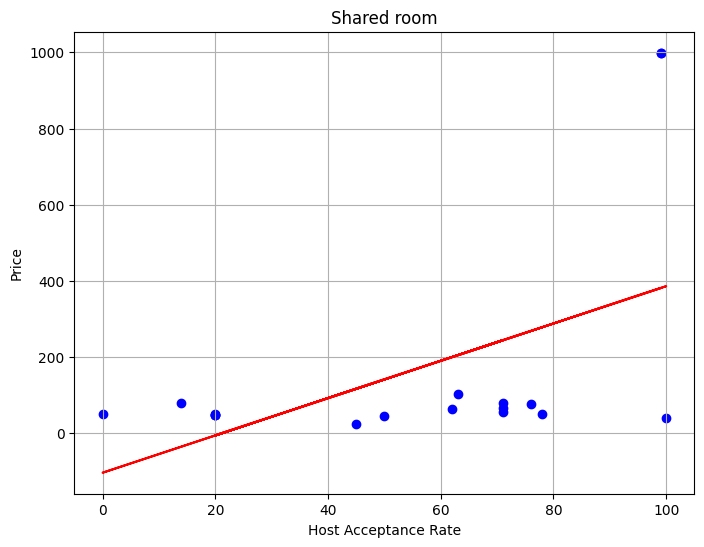

In [16]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_shared[['host_acceptance_rate']], cd_shared['price'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['host_acceptance_rate']], cd_shared['price'], color='blue')
plt.plot(
    cd_shared[['host_acceptance_rate']],
    model.predict(cd_shared[['host_acceptance_rate']]), color='red'
)
plt.title('Shared room')
plt.xlabel('Host Acceptance Rate')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [17]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_shared[['host_acceptance_rate']], cd_shared['price']))

Pendiente: [4.89904643]
Intercepto: -103.95369172117108
y = 4.8990464259255155x + -103.95369172117108

Puntaje del modelo: 0.26538836479017247


In [18]:
# Convertir 'price' a valores numéricos
cd_hotel['price'] = (
    cd_hotel['price']
    .astype(str)  # Convertimos a string para evitar errores
    .str.replace('[$,]', '', regex=True)  # Eliminamos '$' y ','
    .astype(float)  # Convertimos a float
)

# Convertir 'host_acceptance_rate' a float si aún no lo has hecho
cd_hotel['host_acceptance_rate'] = (
    cd_hotel['host_acceptance_rate']
    .astype(str)
    .str.replace('%', '', regex=True)
    .astype(float)
)

# Ahora entrena el modelo
model = LinearRegression()
model.fit(cd_hotel[['host_acceptance_rate']], cd_hotel['price'])


C:\Users\hp\AppData\Local\Temp\ipykernel_14844\3000213699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd_hotel['price'] = (
C:\Users\hp\AppData\Local\Temp\ipykernel_14844\3000213699.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd_hotel['host_acceptance_rate'] = (


LinearRegression()

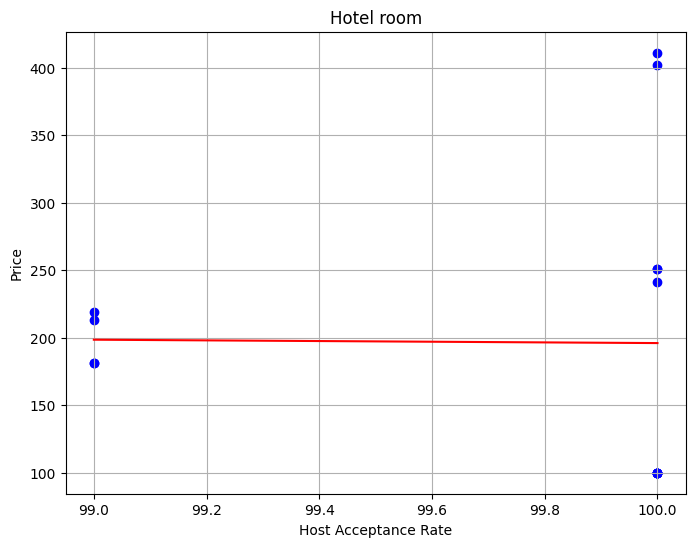

In [19]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_hotel[['host_acceptance_rate']], cd_hotel['price'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['host_acceptance_rate']], cd_hotel['price'], color='blue')
plt.plot(
    cd_hotel[['host_acceptance_rate']], 
    model.predict(cd_hotel[['host_acceptance_rate']]), color='red'
)
plt.title('Hotel room')
plt.xlabel('Host Acceptance Rate')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [20]:
# 1) Obtener los parámetros de la regresión lineal en habitaciones privadas
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Mostrar la ecuación resultante del modelo
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el rendimiento del modelo mediante el coeficiente de determinación (R²)
print('Puntaje del modelo:', model.score(cd_hotel[['host_acceptance_rate']], cd_hotel['price']))

Pendiente: [-2.5]
Intercepto: 445.99999999999955
y = -2.499999999999995x + 445.99999999999955

Puntaje del modelo: 0.00011959641645631347


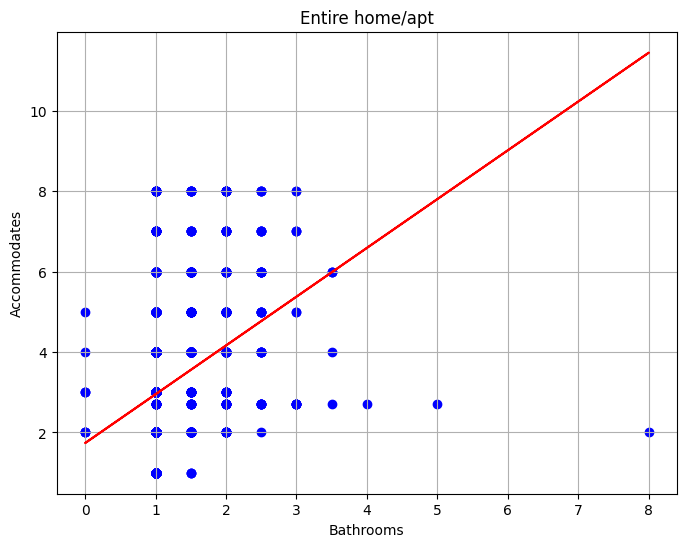

In [28]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_entire[['bathrooms']], cd_entire['accommodates'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['bathrooms']], cd_entire['accommodates'], color='blue')
plt.plot(
    cd_entire[['bathrooms']],
    model.predict(cd_entire[['bathrooms']]), color='red'
)
plt.title('Entire home/apt')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [48]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_entire[['bathrooms']], cd_entire['accommodates']))

Pendiente: [0.56024288]
Intercepto: 2.854045154236769
y = 0.5602428753007621x + 2.854045154236769

Puntaje del modelo: 0.11322119326031943


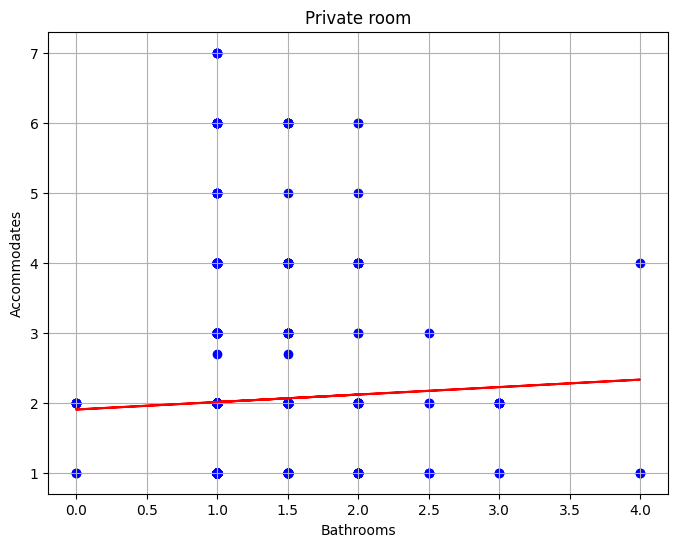

In [29]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_private[['bathrooms']], cd_private['accommodates'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['bathrooms']], cd_private['accommodates'], color='blue')
plt.plot(
    cd_private[['bathrooms']],
    model.predict(cd_private[['bathrooms']]), color='red'
)
plt.title('Private room')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [30]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_private[['bathrooms']], cd_private['accommodates']))

Pendiente: [0.10664155]
Intercepto: 1.9032164145006694
y = 0.10664155391021739x + 1.9032164145006694

Puntaje del modelo: 0.001549131463522535


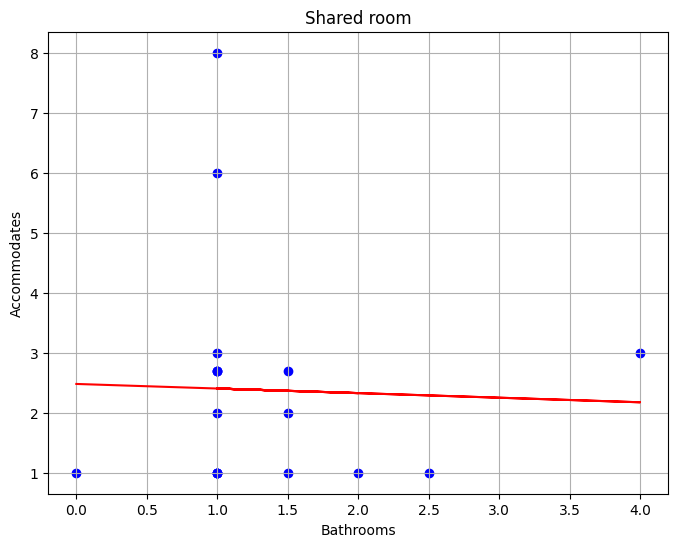

In [36]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_shared[['bathrooms']], cd_shared['accommodates'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['bathrooms']], cd_shared['accommodates'], color='blue')
plt.plot(
    cd_shared[['bathrooms']], 
    model.predict(cd_shared[['bathrooms']]), color='red'
)
plt.title('Shared room')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [37]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_shared[['bathrooms']], cd_shared['accommodates']))

Pendiente: [-0.07638889]
Intercepto: 2.4796296296296294
y = -0.07638888888888884x + 2.4796296296296294

Puntaje del modelo: 0.0011406072781678933


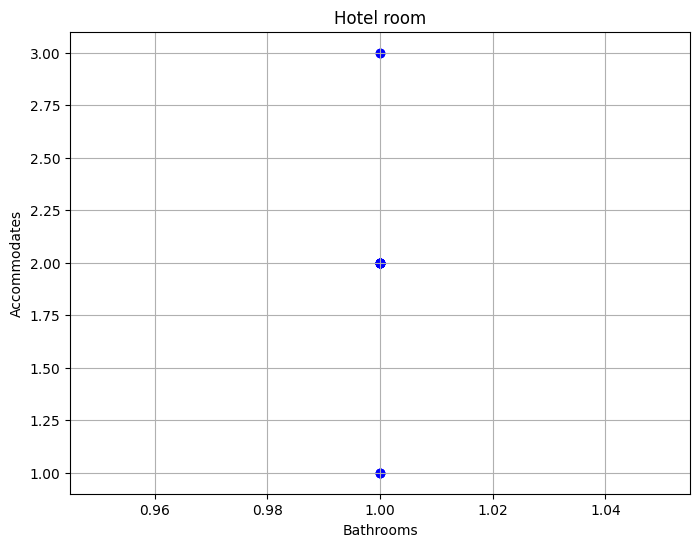

In [38]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_hotel[['bathrooms']], cd_hotel['accommodates'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['bathrooms']], cd_hotel['accommodates'], color='blue')
plt.plot(
    cd_hotel[['bathrooms']],
    model.predict(cd_hotel[['bathrooms']]), color='red'
)
plt.title('Hotel room')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [39]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_hotel[['bathrooms']], cd_hotel['accommodates']))

Pendiente: [0.]
Intercepto: 1.9333333333333333
y = 0.0x + 1.9333333333333333

Puntaje del modelo: 0.0


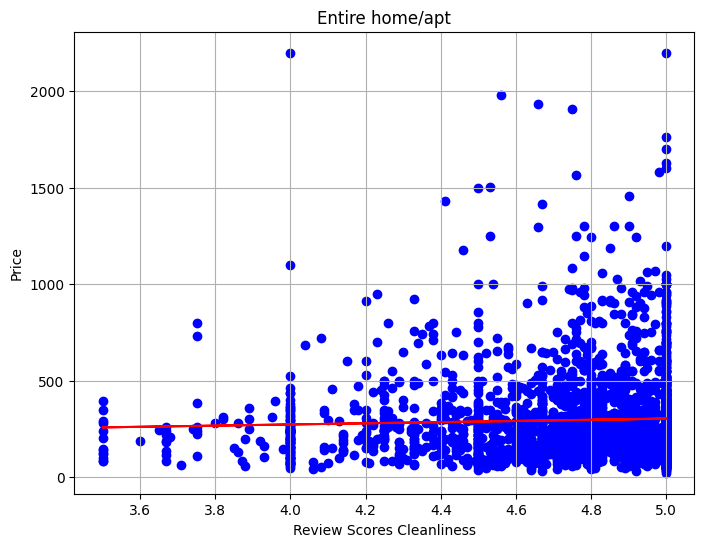

In [40]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_entire[['review_scores_cleanliness']], cd_entire['price'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['review_scores_cleanliness']], cd_entire['price'], color='blue')
plt.plot(
    cd_entire[['review_scores_cleanliness']], 
    model.predict(cd_entire[['review_scores_cleanliness']]), color='red'
)
plt.title('Entire home/apt')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [42]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_entire[['review_scores_cleanliness']], cd_entire['price']))

Pendiente: [30.30051202]
y = 30.300512015213272x + 151.8416371161058

Puntaje del modelo: 0.0015334931991713985


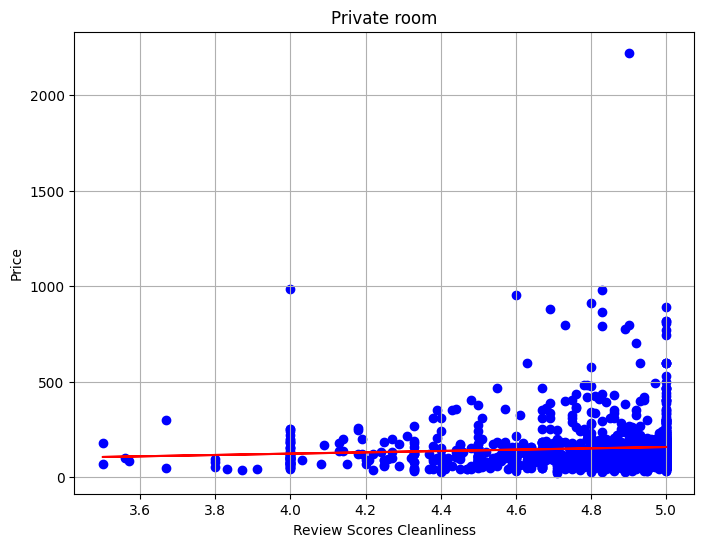

In [43]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_private[['review_scores_cleanliness']], cd_private['price'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['review_scores_cleanliness']], cd_private['price'], color='blue')
plt.plot(
    cd_private[['review_scores_cleanliness']],
    model.predict(cd_private[['review_scores_cleanliness']]), color='red'
)
plt.title('Private room')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [44]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_private[['review_scores_cleanliness']], cd_private['price']))


Pendiente: [34.88160694]
y = 34.88160694316117x + -16.687711149470573

Puntaje del modelo: 0.005025057739127314


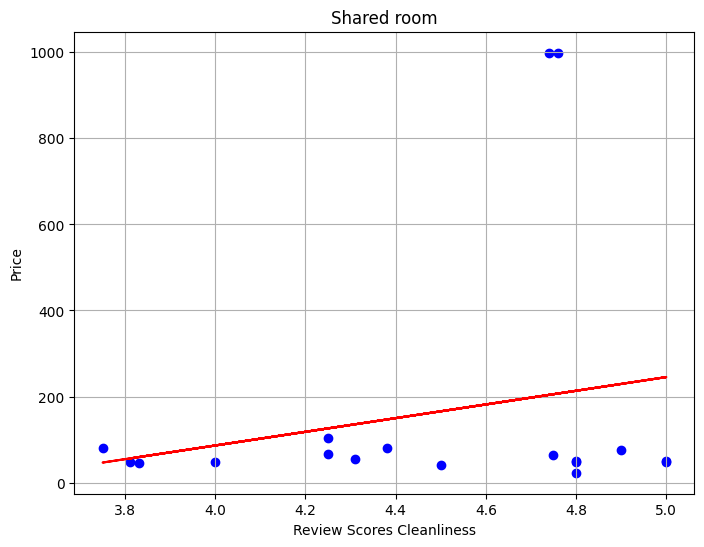

In [45]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_shared[['review_scores_cleanliness']], cd_shared['price'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['review_scores_cleanliness']], cd_shared['price'], color='blue')
plt.plot(
    cd_shared[['review_scores_cleanliness']],
    model.predict(cd_shared[['review_scores_cleanliness']]), color='red'
)
plt.title('Shared room')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [46]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_shared[['review_scores_cleanliness']], cd_shared['price']))

Pendiente: [158.88190357]
y = 158.8819035682717x + -549.2026602616526

Puntaje del modelo: 0.04829585143708459


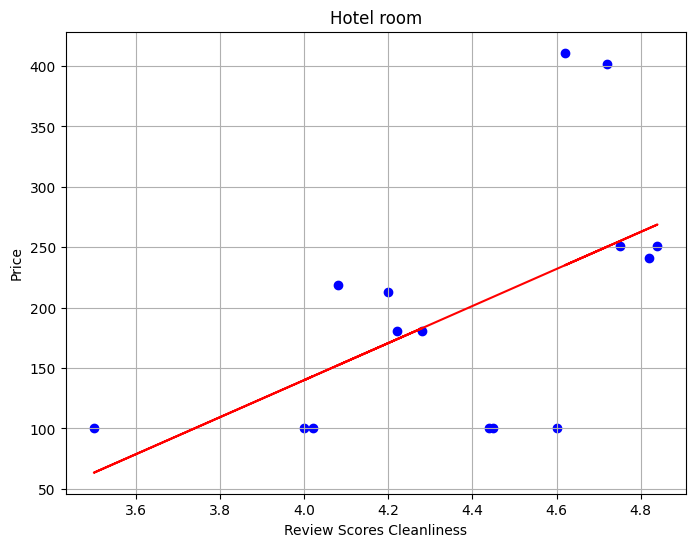

In [47]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_hotel[['review_scores_cleanliness']], cd_hotel['price'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['review_scores_cleanliness']], cd_hotel['price'], color='blue')
plt.plot(cd_hotel[['review_scores_cleanliness']], model.predict(cd_hotel[['review_scores_cleanliness']]), color='red')
plt.title('Hotel room')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [48]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_hotel[['review_scores_cleanliness']], cd_hotel['price']))

Pendiente: [153.29945301]
Intercepto: -473.14974336838316
y = 153.29945301381974x + -473.14974336838316

Puntaje del modelo: 0.303068765105189


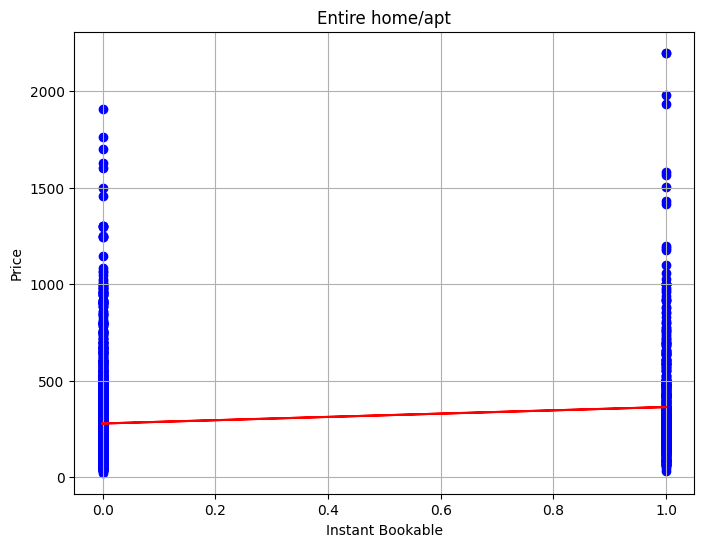

In [50]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_entire[['instant_bookable']], cd_entire['price'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['instant_bookable']], cd_entire['price'], color='blue')
plt.plot(
    cd_entire[['instant_bookable']],
    model.predict(cd_entire[['instant_bookable']]), color='red'
)
plt.title('Entire home/apt')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [51]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_entire[['instant_bookable']], cd_entire['price']))

Pendiente: [85.22657807]
Intercepto: 278.0758793969851
y = 85.22657806993303x + 278.0758793969851

Puntaje del modelo: 0.022572740334665276


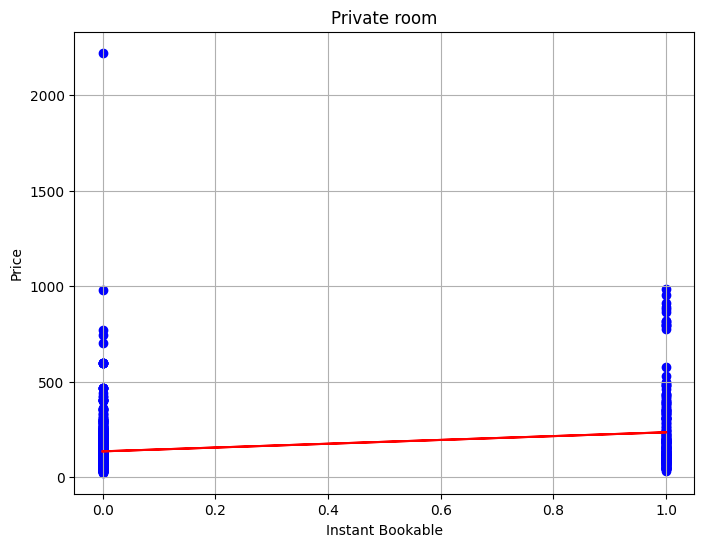

In [52]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_private[['instant_bookable']], cd_private['price'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['instant_bookable']], cd_private['price'], color='blue')
plt.plot(
    cd_private[['instant_bookable']],
    model.predict(cd_private[['instant_bookable']]), color='red'
)
plt.title('Private room')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [53]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_private[['instant_bookable']], cd_private['price']))

Pendiente: [99.77869165]
Intercepto: 134.86090225563905
y = 99.77869165299067x + 134.86090225563905

Puntaje del modelo: 0.07443905691882846


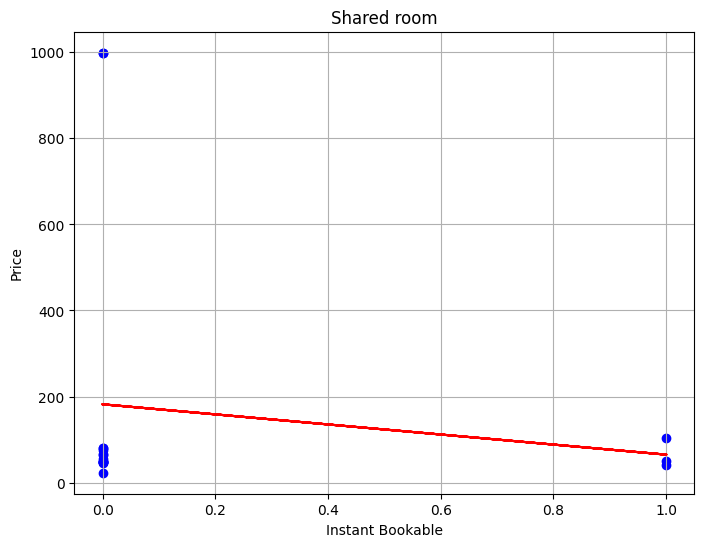

In [54]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_shared[['instant_bookable']], cd_shared['price'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['instant_bookable']], cd_shared['price'], color='blue')
plt.plot(cd_shared[['instant_bookable']], model.predict(cd_shared[['instant_bookable']]), color='red')
plt.title('Shared room')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [55]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_shared[['instant_bookable']], cd_shared['price']))

Pendiente: [-117.]
Intercepto: 182.0
y = -116.99999999999999x + 182.0

Puntaje del modelo: 0.021658130936050846


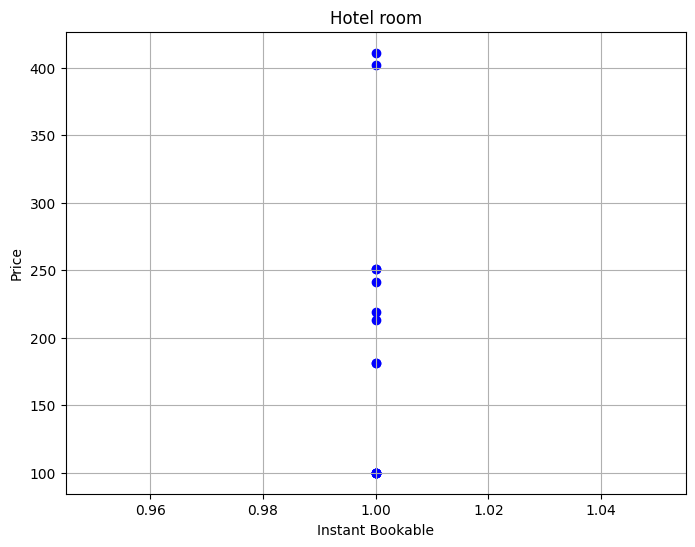

In [56]:
# 1) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_hotel[['instant_bookable']], cd_hotel['price'])

# 2) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['instant_bookable']], cd_hotel['price'], color='blue')
plt.plot(
    cd_hotel[['instant_bookable']],
    model.predict(cd_hotel[['instant_bookable']]), color='red'
)
plt.title('Hotel room')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [57]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_hotel[['instant_bookable']], cd_hotel['price']))

Pendiente: [0.]
Intercepto: 196.66666666666666
y = 0.0x + 196.66666666666666

Puntaje del modelo: 0.0


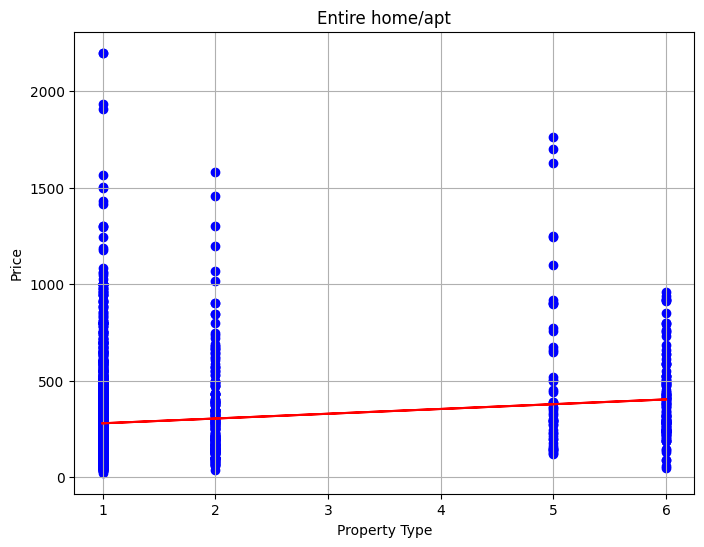

In [58]:

# 1) Filtrar valores no numéricos en la columna "property_type" del dataframe cd_entire

cd_entire = cd_entire[pd.to_numeric(cd_entire['property_type'], errors='coerce').notnull()]

# 2) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_entire[['property_type']], cd_entire['price'])

# 3) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['property_type']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['property_type']], model.predict(cd_entire[['property_type']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [59]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_entire[['property_type']], cd_entire['price']))

Pendiente: [24.74914465]
Intercepto: 254.30539435391034
y = 24.74914464620869x + 254.30539435391034

Puntaje del modelo: 0.022932653725509122


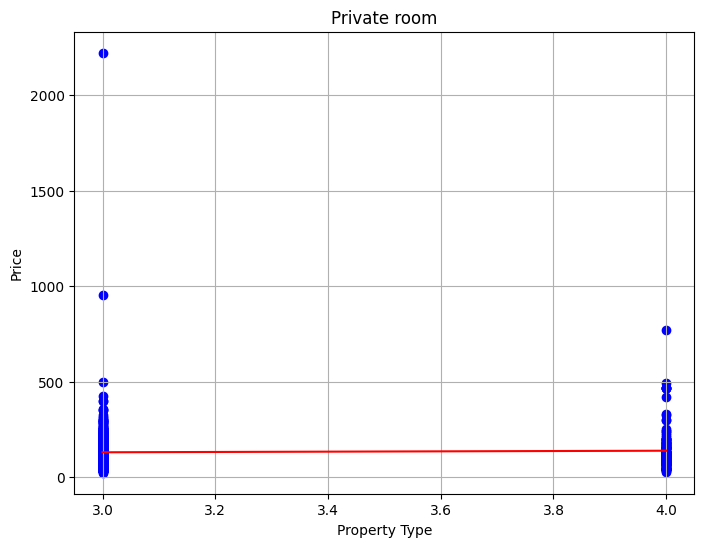

In [60]:
# ---------------------------------------------------------------------------------
# 1) Filtrar valores no numéricos en la columna "property_type" del dataframe cd_private

cd_private = cd_private[pd.to_numeric(cd_private['property_type'], errors='coerce').notnull()]

# 2) Crear y ajustar un modelo de regresión lineal
model = LinearRegression()
model.fit(cd_private[['property_type']], cd_private['price'])

# 3) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['property_type']], cd_private['price'], color='blue')
plt.plot(cd_private[['property_type']], model.predict(cd_private[['property_type']]), color='red')
plt.title('Private room')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [61]:
# 1) Obtener los parámetros (pendiente y ordenada en el origen) del modelo
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# 2) Representar el modelo lineal de forma explícita
print(f'y = {m[0]}x + {b}', end='\n\n')

# 3) Evaluar el modelo con un indicador de desempeño
print('Puntaje del modelo:', model.score(cd_private[['property_type']], cd_private['price']))

Pendiente: [8.16669008]
Intercepto: 105.54707617397823
y = 8.166690076002295x + 105.54707617397823

Puntaje del modelo: 0.0009119465017425332


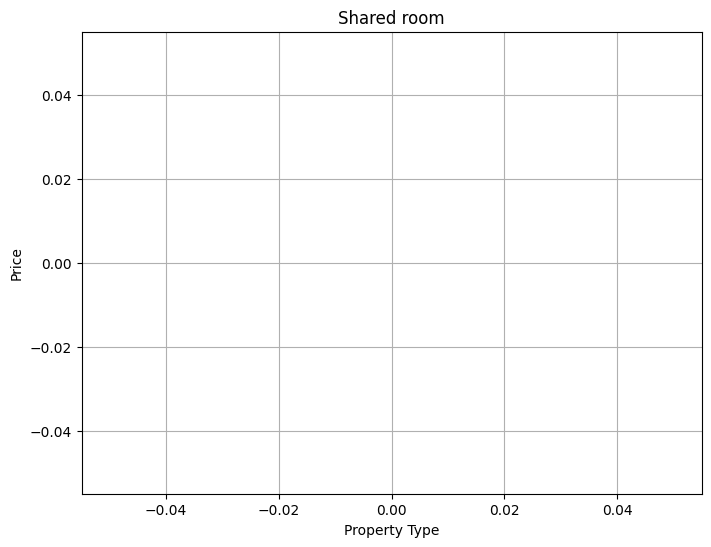

In [62]:
# 1) Filtrar valores no numéricos en la columna "property_type" del dataframe cd_shared

cd_shared = cd_shared[pd.to_numeric(cd_shared['property_type'], errors='coerce').notnull()]

# ---------------------------------------------------------------------------------
# 2) Crear instancia del modelo (aunque en este caso no entrenamos el modelo debido
#    a que al parecer no existen registros de los 6 tipos de propiedad deseados).


model = LinearRegression()
#plt.plot(ny_shared[['property_type']], model.predict(ny_shared[['property_type']]), color='red')

# ---------------------------------------------------------------------------------
# 3) Visualizar la distribución de 'property_type' contra 'price'
#    - Trazamos únicamente el diagrama de dispersión (scatter), sin la línea de regresión.

plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['property_type']], cd_shared['price'])
# plt.plot(...)  # Línea de regresión comentada, ya que no se ha entrenado el modelo

plt.title('Shared room')         # Título de la gráfica
plt.xlabel('Property Type')       # Etiqueta del eje X
plt.ylabel('Price')               # Etiqueta del eje Y
plt.grid(True)                    # Cuadrícula para facilitar la lectura
plt.show()                        # Muestra la gráfica


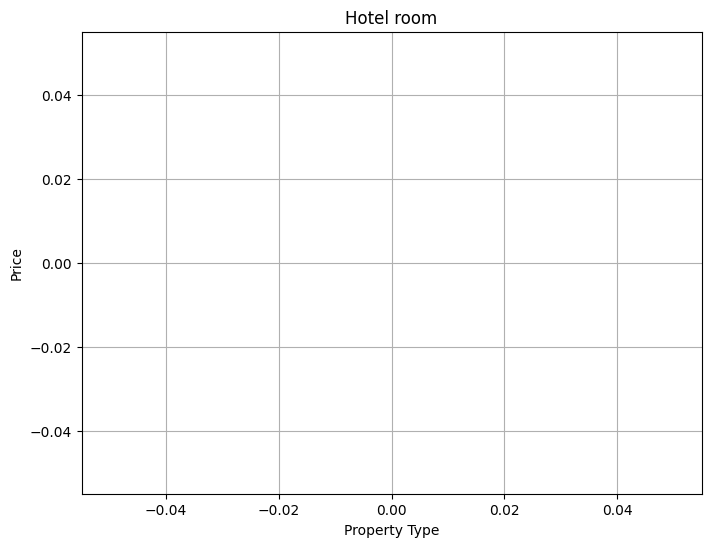

In [63]:
# 1) Filtrar valores no numéricos en la columna "property_type"
cd_hotel = cd_hotel[pd.to_numeric(cd_hotel['property_type'], errors='coerce').notnull()]

# 2) Crear y entrenar un modelo de regresión lineal
model = LinearRegression()
#model.fit(cd_hotel[['property_type']], cd_hotel['price'])

# 3) Visualizar la relación y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['property_type']], cd_hotel['price'], color='blue')
#plt.plot(cd_hotel[['property_type']], model.predict(cd_hotel[['property_type']]), color='red')
plt.title('Hotel room')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(True)
plt.show()